# An Introduction to Compressio

`Compressio` is a simple package designed to reduce memory usage when working with pandas objects. This is accomplished through a few mechanisms.

1. Using more efficient data type representations like 8 bit integers, when possible, rather than the 64 bit integers reserved by default.
2. (Optionally) type coercion where possible. Substanial memory savings can be achieved by detecting alternative representations for sequences which protect their semantic meaning. For example, the sequence of strings `['1', '2', '3']` can be losslessly coerced to 8 bit integers `[1, 2, 3]`. The int8 representation ends up with a memory footprint less than half the size of it's string counterpart.
3. Sparse representations. A regular component of many data workflows involves dealing with low cardinality or sparse fields. This might mean having many missing values in a sequence or simply duplicated values in which case `Compressio` will find an alternative, dense, representation for your data.

Let's load some data and see this in action. For this example we will be playing with a sample of data covering salary and titles in Chicago.

In [1]:
import pandas as pd
url = "https://data.cityofchicago.org/api/views/xzkq-xp2w/rows.csv?accessType=DOWNLOAD"
df = pd.read_csv(url)
df.head()

,Name,Job Titles,Department,Full or Part-Time,Salary or Hourly,Typical Hours,Annual Salary,Hourly Rate
0,"AARON, JEFFERY M",SERGEANT,POLICE,F,Salary,NaN,111444.0,NaN
1,"AARON, KARINA",POLICE OFFICER (ASSIGNED AS DETECTIVE),POLICE,F,Salary,NaN,94122.0,NaN
2,"AARON, KIMBERLEI R",CHIEF CONTRACT EXPEDITER,DAIS,F,Salary,NaN,118608.0,NaN
3,"ABAD JR, VICENTE M",CIVIL ENGINEER IV,WATER MGMNT,F,Salary,NaN,117072.0,NaN
4,"ABARCA, EMMANUEL",CONCRETE LABORER,TRANSPORTN,F,Hourly,40.0,NaN,44.4


# Basic Usage

Getting started with compressio is simple, and fully customizable both in the compression algorithms used and the sort of data those algorithms are applied to. However, it comes with a set of sensible defaults which should apply to most use cases out of the box.

In [2]:
from compressio import Compress

compress = Compress()
df_compressed = compress.it(df)

That's really it, we grab a `Compress` object out of compressio and pass our source dataframe to it. If you're only working with a series it can be compressed just as easily

In [3]:
compressed_series = compress.it(df['Department'])

The real question is how much memory did this save us though?

In [4]:
from compressio import savings_report
savings_report(df, df_compressed)

Original size: 11.826331999999999 megabyte
Compressed size: 3.00723 megabyte
Savings: 8.819101999999999 megabyte
Reduction percentage: 74.57%


Not bad! A few lines of code bought a 75% reduction in size on a fairly random mix of data.

# How it works

First let's check out the types of our data.


In [5]:
df.dtypes

Name                  object
Job Titles            object
Department            object
Full or Part-Time     object
Salary or Hourly      object
Typical Hours        float64
Annual Salary        float64
Hourly Rate          float64
dtype: object

Let's see what compressio did with the data

In [6]:
df_compressed.dtypes

Name                   object
Job Titles           category
Department           category
Full or Part-Time    category
Salary or Hourly     category
Typical Hours         float16
Annual Salary         float32
Hourly Rate           float16
dtype: object

It found that `Typical Hours` and `Hourly Rate` could be equivalently represented with only 16 bit precision and that `Job Titles`, `Department`, `Full or Part-Time`, and `Salary or Hourly` were all low cardinality fields which it could compress using pandas built in category type. `Name` on the other hand was already dense (i.e. mostly unique) and therefore left alone.

If we inspect a little more closely we can see that `Typical Hours` is actually entirely integer but has been coerced to float because of the presence of missing values.

In [7]:
df['Typical Hours'].unique()

array([nan, 40., 20., 35., 10.])

If you're willing to let `Compressio` infer alternative representations for your data we can save even more memory by coercing these down to integers, again very simply

In [8]:
compress = Compress(with_type_inference=True)
compress.it(df['Typical Hours']).dtype

UInt8Dtype()

# Customization

Behind the scenes, the Compress object is composed of two primary objects

1. A typeset covering the semantic types of data to compress. These could be simple (Integer, Float, String, etc...) or more complex (files, shapely geometries, etc...)
2. A `compressio.Compressor` whose job is to map semantic data types in a typeset to an appropriate compression algorith,.

This type system abstraction over arbitrary sequences is provided by [visions](https://github.com/dylan-profiler/visions) and allows us to easily build highly granular and sequence specific compression algorithms.


## The TypeSet

Each typeset defines the rules for either checking sequence types or inferring alternative representations of the data. Although, the full details of the system are beyond the scope of this post you can find more details in my `visions` tutorial [here](http://www.ianeaves.com/post/titanic-visions/).


So what's in the default compression typeset?

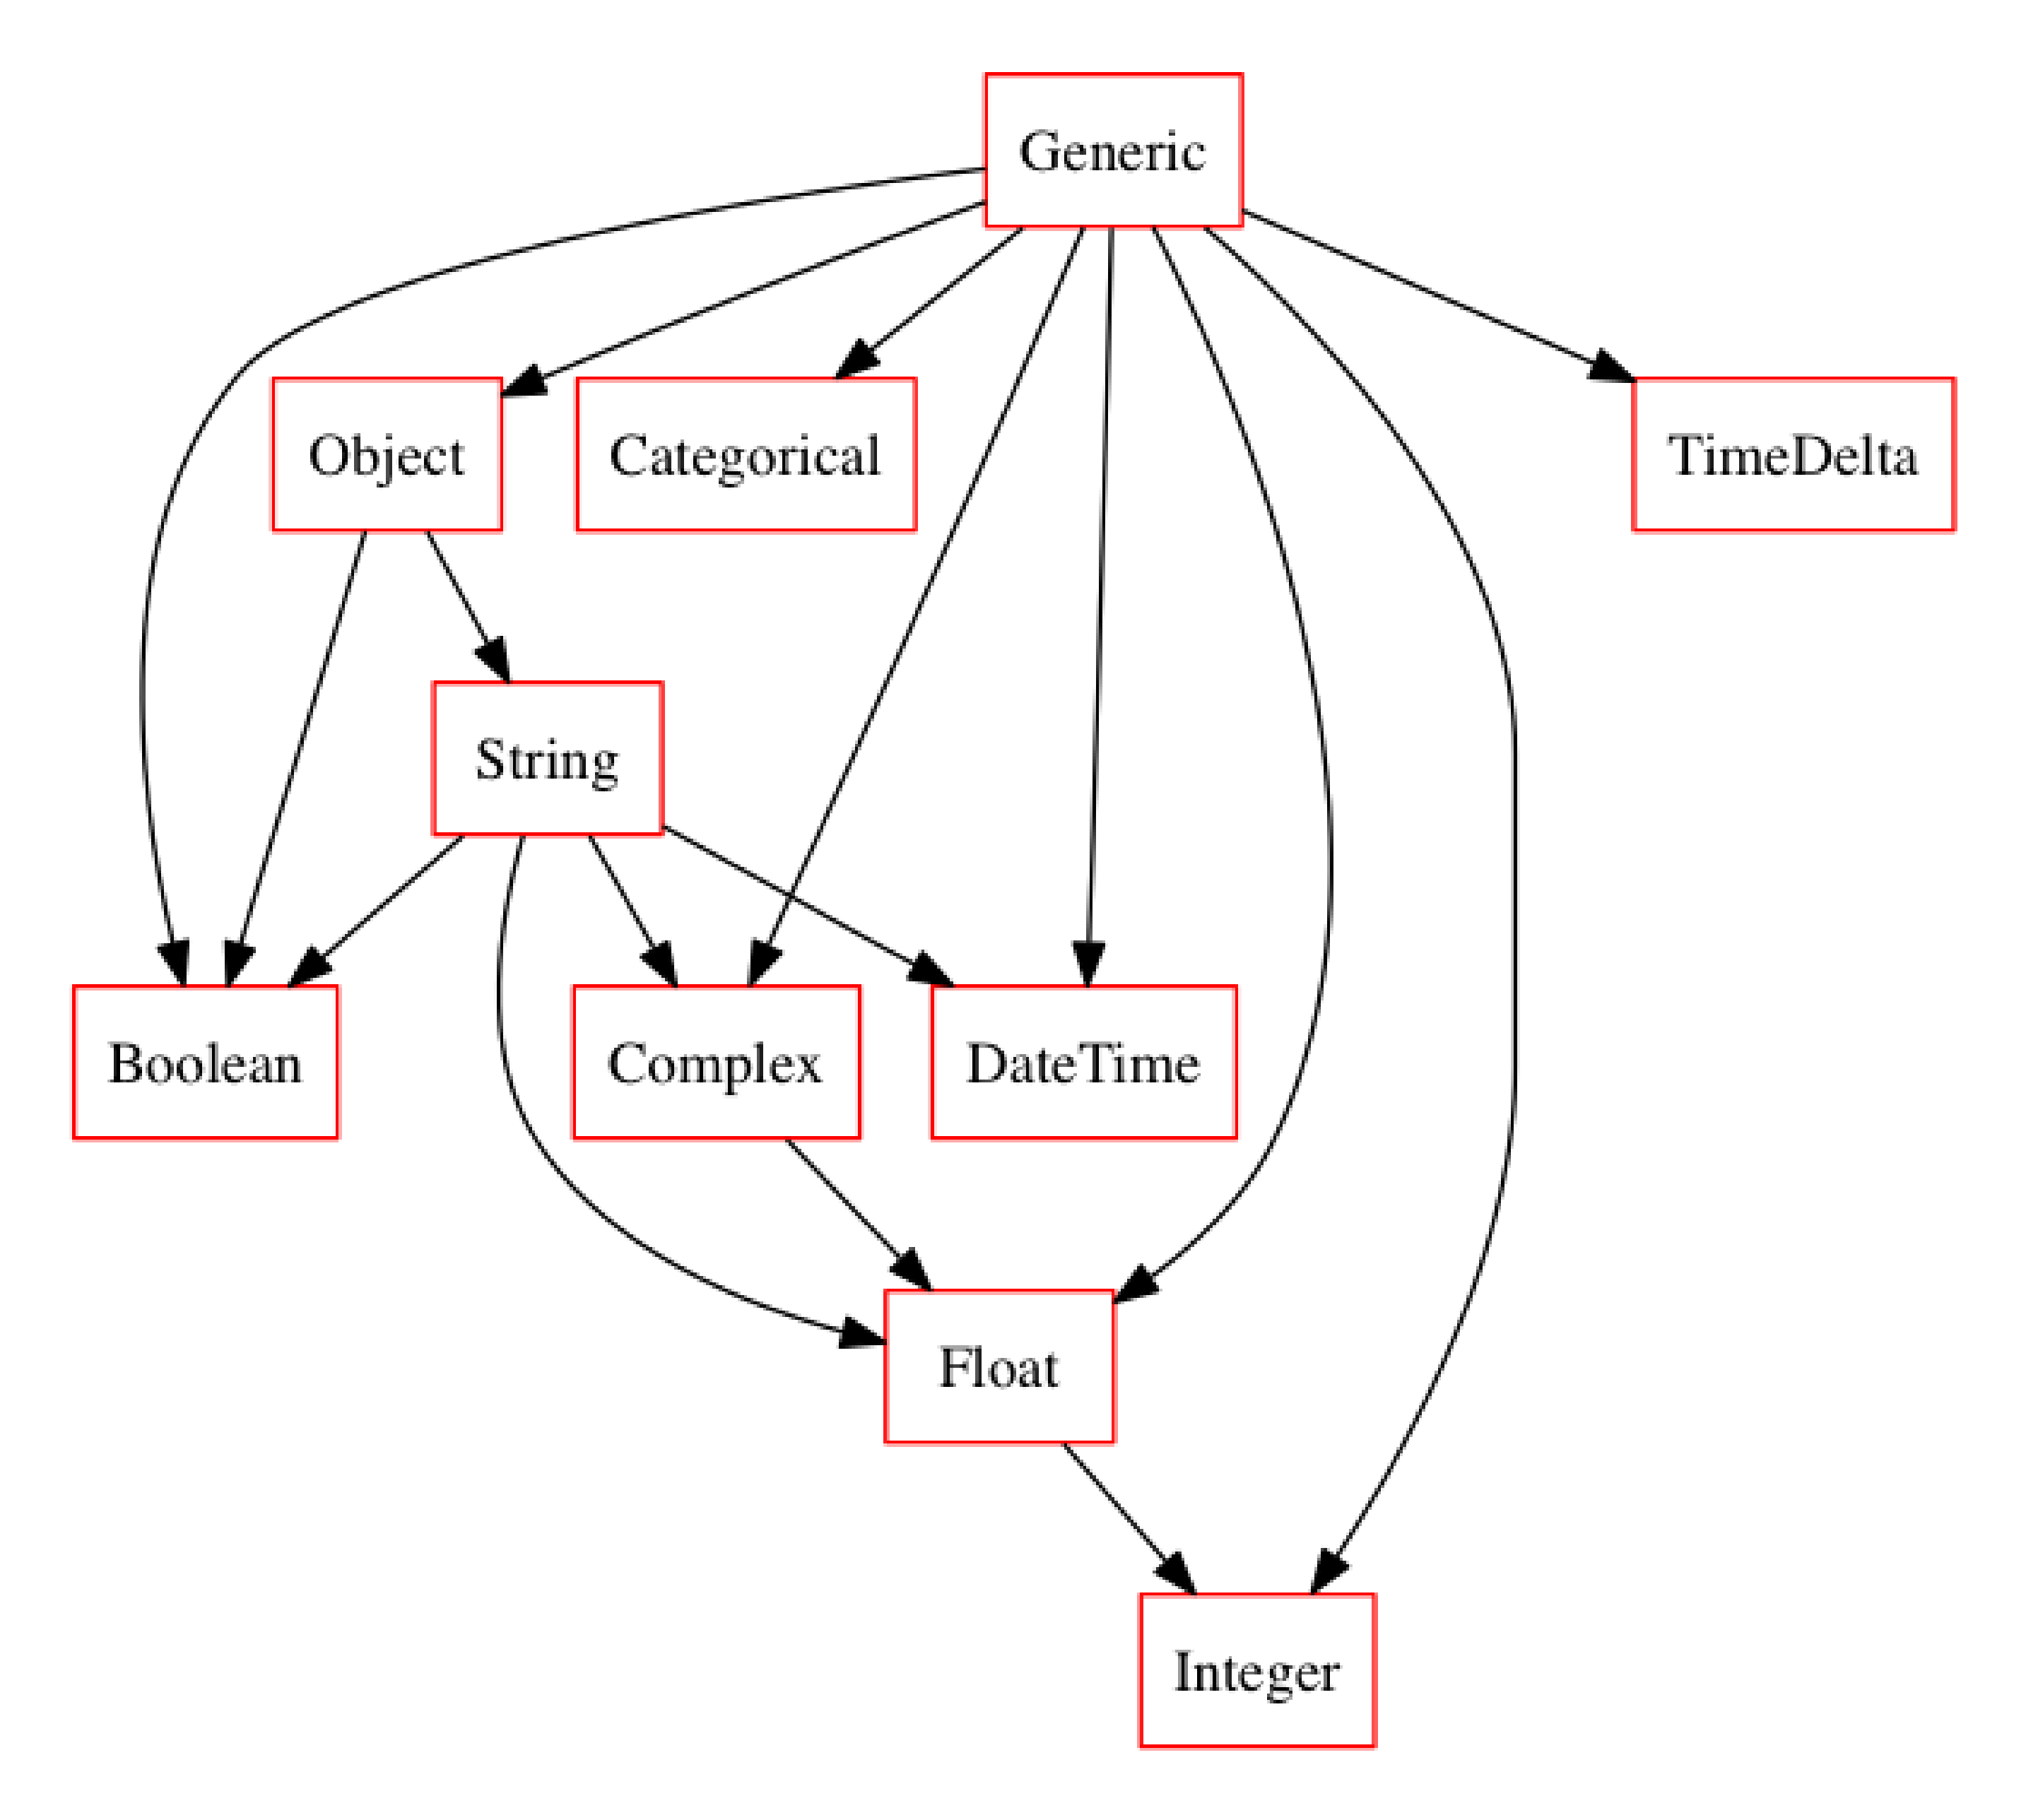

In [9]:
compress.typeset.plot_graph()

Although the default system is already quite robust, you can extend and customize it however suits your specific application by simply passing your preferred typeset into the `Compress` object upon instantiation. Let's grab a larger typeset from visions and see how that looks.

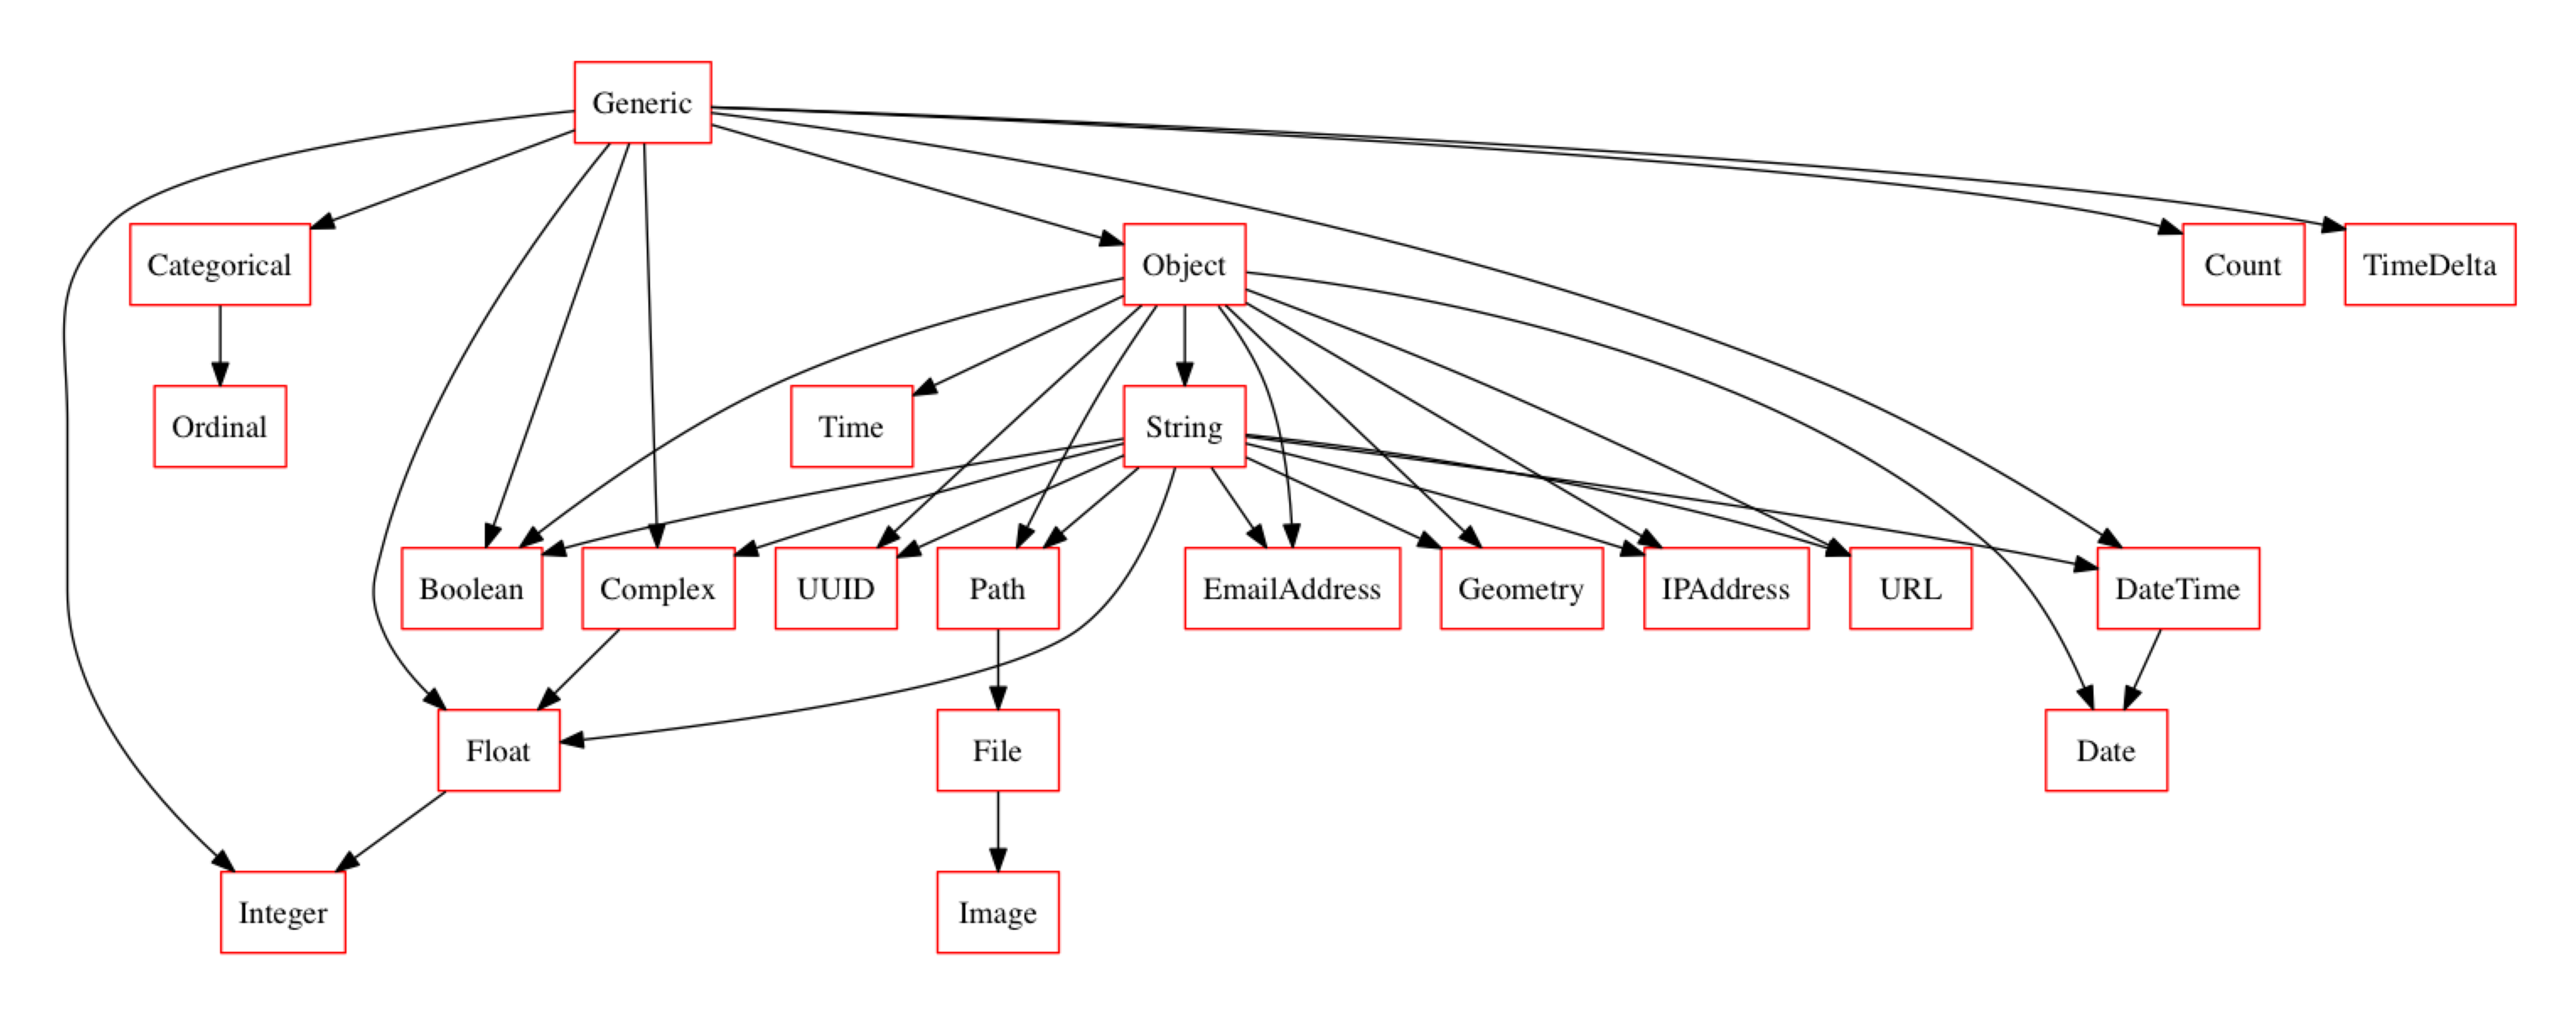

In [10]:
from visions import CompleteSet

compress = Compress(CompleteSet(), with_type_inference=True)
compress.typeset.plot_graph()

## The Compressor

Is a simple abstraction mapping `types -> compression_algorithms` and can be customized for your usecase. Let's run through a simple example where we are dealing with geometries and only require the convex hull of each element rather than complete polygons.

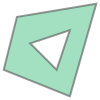

In [11]:
from shapely import wkt
import random

my_polygon = wkt.loads("POLYGON ((35.0 10, 45 45, 15 40, 10 20, 35 10),(20 30, 35 35, 30 20, 20 30))")
series = pd.Series([my_polygon for i in range(1000)])

series[0]

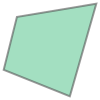

In [12]:
from compressio.type_compressor import BaseTypeCompressor
from visions.types import Geometry

def compress_polygon(series):
    return series.apply(lambda x: x.convex_hull)

my_compressor = BaseTypeCompressor({Geometry: compress_polygon})

compress = Compress(CompleteSet(), my_compressor, with_type_inference=True)
new_series = compress.it(series)

new_series[0]

# Wrapping Up

Most users will be well suited by the default functionality found in `compressio` but thanks to the flexible type system provided by `visions` it should be possible to meet the needs of even niche users. We are always looking for new contributions so please check the project out on [github](https://github.com/dylan-profiler/compressio) and happy compressing.